In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

from data_augmentation_overview import Data_augmentation, Dataset_overview
from data_train_valid import Data_train_valid

from drumdataset_load import DrumDataset, DrumDataset_test

from models import VGG19
from models import ResNet34, ResidualBlock
from models import EfficientNet

In [3]:
with open('./info.json', 'r') as f:
    info = json.load(f)
    
labels = info["labels"]
data_version = info["data_version"]
dataset_t_v_path = info["path"]["t_v_data"][:-1]
dataset_test_path = info["path"]["t_v_data"][-1]
data_type = info["data_type"]
data_info = info["data_n"]
data_time_path = info["path"]["time_data"]
data_mel_path = info["path"]["mel_data"]

vgg_para = info["hyperparameter"]["vgg"]
resnet_para = info["hyperparameter"]["resnet"]
efficientnet_para = info["hyperparameter"]["efficientnet"]

# Download Data Set

In [3]:
import gdown 
google_path = 'https://drive.google.com/uc?id=' 
file_id = '1VsgbtqBhVnCDpXgp9ydW53eBkfDRq7Tf' 
output_name = 'drumdataset.egg' 
gdown.download(google_path+file_id,output_name,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VsgbtqBhVnCDpXgp9ydW53eBkfDRq7Tf
To: C:\Users\ADmin\Desktop\drumdataset\drumdataset.egg
5.06GB [07:51, 10.7MB/s]


'drumdataset.egg'

# Data Augmentation

### Generate Augmentation Folder

In [11]:
data_augmentation = Data_augmentation(labels)

In [4]:
data_augmentation.make_aug_folders(True)

You already have folders


In [ ]:
class_n = len(labels)
aug_n = 3
for i in range(class_n):
    data_augmentation.export_data(aug_n,i)

### Dataset Overview

In [9]:
data_overview = Dataset_overview(labels,data_version)

In [10]:
data_overview.overview()

,dataset_v1,dataset_aug,dataset_v2,dataset_v3,dataset_v4
CH,440,1320,2415,948,110
B+CH,440,1320,1731,593,110
OH,440,1320,636,461,110
S+CH,440,1320,1084,309,110
S+OH,438,1314,313,370,110
B+OH,440,1320,469,391,110
B,440,1320,105,282,110
S,440,1320,88,134,110
R,440,1320,661,283,110
B+R,440,1320,473,236,110


### Confirm all of Dataset Image Size

In [25]:
data_overview.confirm_size()

All images size is (256,384,3)


# Training and Validation Dataset 

In [7]:
data_t_v = Data_train_valid(labels,dataset_t_v_path,data_type,data_time_path,data_mel_path)

### Generate Training and Validation Folders

In [8]:
data_t_v.make_folders(status=True)

Complete folders generation


### Generate Training and Validation Data

In [9]:
data_t_v.gen_t_v(data_info)

Label- CH : train- 1202, valid- 118
Label- B+CH : train- 1202, valid- 118
Label- OH : train- 1202, valid- 118
Label- S+CH : train- 1202, valid- 118
Label- S+OH : train- 1200, valid- 120
Label- B+OH : train- 1202, valid- 118
Label- B : train- 1200, valid- 120
Label- S : train- 1200, valid- 120
Label- R : train- 1202, valid- 118
Label- B+R : train- 1202, valid- 118
Label- S+R : train- 1200, valid- 120
Label- B+C : train- 1200, valid- 120
Label- rest : train- 1200, valid- 120
Label- MT : train- 1200, valid- 120
Label- S+B+CH : train- 1200, valid- 120
Label- FT : train- 1200, valid- 120
Label- S+FT : train- 1200, valid- 120
Label- S+B : train- 1200, valid- 120
Label- S+C : train- 1200, valid- 120
Label- S+B+R : train- 1200, valid- 120
Label- B+FT : train- 1200, valid- 120
Label- S+B+OH : train- 1200, valid- 120
Label- MT+FT : train- 1200, valid- 120


# Train and Validate - VGG19, ResNet34, EfficientNet-B0, B1, B2

In [3]:
train_dataset = DrumDataset(labels,train = True, dtype = 'mel')
valid_dataset = DrumDataset(labels,train = False, dtype = 'mel')

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, pin_memory = True)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = True, pin_memory = True)

del train_dataset
del valid_dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = EfficientNet.from_name('efficientnet-b0',in_channels=3, num_classes = 23) # VGG19(in_channel=4) // ResNet34(ResidualBlock, resnet_para[2], in_channel=4) // EfficientNet.from_name('efficientnet-b"n"',in_channels=4, num_classes = 23)
net.train()
net.to(device)

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(),lr=efficientnet_para[0])
decayRate = efficientnet_para[1]
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

iteration = 0
iterations = []
acc_trains = []
loss_trains = []
acc_valids = []
loss_valids = []

correct_valid = 0
total_valid = 0
correct_train = 0
total_train = 0


for epoch in range(40):  # loop over the dataset multiple times
    running_loss_train = 0.0

    for i, data in enumerate(train_loader, 0):
        # get the inputs
        net.train()
        input_train, label_train = data
        del data
        input_train, label_train = input_train.to(device).float(), label_train.to(device).long()
        # zero the parameter gradients
        optimizer.zero_grad()
        pred_train = net(input_train)
        #del input_train
        loss_train = criterion(pred_train, label_train)

        loss_train.backward()
        optimizer.step()
        
        _, p_train = torch.max(pred_train, 1)
        correct_train += torch.sum(p_train == label_train)
        total_train += len(label_train)
            
        iteration += 1
        # print statistics
        running_loss_train += loss_train.item()
        
        if i % 400 == 399:    # size of mini-batches (8) (per 400 iteration)  
            acc_train = 100*correct_train/total_train
        
            net.eval()
            with torch.no_grad():
                running_loss_valid = 0.0
                for j, data in enumerate(valid_loader):
                    input_valid, label_valid = data
                    del data
                    input_valid, label_valid = input_valid.to(device).float(), label_valid.to(device).long()

                    pred_valid = net(input_valid)
                    del input_valid

                    loss_valid = criterion(pred_valid, label_valid)
                    running_loss_valid += loss_valid.item()
                    _, p_valid = torch.max(pred_valid, 1)
                    
                    correct_valid += torch.sum(p_valid == label_valid)
                    total_valid += len(label_valid)
                    
                acc_valid = 100*correct_valid/total_valid
                del correct_valid, total_valid
                acc_valids.append(acc_valid)
                loss_valids.append(running_loss_valid/j)
                
            acc_trains.append(acc_train)
            loss_trains.append(running_loss_train/400)
            
            iterations.append(iteration)
            
            print('[%d, %5d] loss_t: %.3f, accuracy_t: %.3f, loss_v: %.3f, accuracy_v: %.3f - iteration(400) : %d' %
                  (epoch + 1, i + 1, running_loss_train / 400, acc_train, running_loss_valid/j, acc_valid, iteration // 400))
            
            correct_train = 0
            total_train = 0
            correct_valid = 0
            total_valid = 0
            running_loss_train = 0.0
            running_loss_valid = 0.0
            
            if epoch >= 2:
                save_path = "E:/efficientnet_b0_result_epoch_"+str(epoch)+"_"+ str(iteration // 400) +".pth"
            else:
                save_path = "E:/efficientnet_b0_result.pth"
            torch.save(net.state_dict(), save_path)
            
    lr_scheduler.step()
    
print('Finished Training')

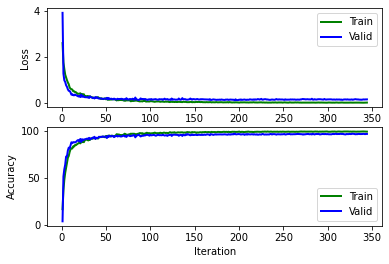

In [8]:
plt.subplot(2,1,1)
plt.plot(iterations,loss_trains, color='green', linewidth=2)
plt.plot(iterations,loss_valids, color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.xlim(0,4600*3)
plt.legend(['Train', 'Valid'])

plt.subplot(2,1,2)
plt.plot(iterations,acc_trains, color='green', linewidth=2)
plt.plot(iterations,acc_valids, color='blue', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
#plt.xlim(0,4600*3)
plt.legend(['Train', 'Valid'])

In [6]:
efficientnet_b0_loss_acc = {'iteration':iterations, 'loss_train':loss_trains, 'loss_valid':loss_valids, 'acc_train':acc_trains, 'acc_valid':acc_valids}
with open('E:/loss,accuracy/efficientnet_b0_loss_acc.pickle','wb') as fw:
    pickle.dump(efficientnet_b0_loss_acc, fw)
    
# with open('E:/loss,accuracy/efficientnet_b0_loss_acc.pickle','rb') as fr:
#     data = pickle.load(fr)

C:\Users\ADmin\anaconda3\envs\new_torch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


# Validation - VGG19, ResNet34, EfficientNet-B0, B1, B2

In [13]:
valid_dataset = DrumDataset(labels,train = False,dtype='mel')
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = True, num_workers = 0)

del valid_dataset

In [17]:
total_valid = 0
correct_valid = 0
correct_valid_3 = 0
pred = []
corr = []

save_path="E:parameter/efficientnet_b0_result_mel_aug.pth"

net = EfficientNet.from_name('efficientnet-b0',in_channels=3, num_classes = 23)
net.load_state_dict(torch.load(save_path))
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

with torch.no_grad():
    for input_valid,label_valid in valid_loader:
        input_valid = input_valid.cuda()
        label_valid = label_valid.cuda()
        input_valid = input_valid.to("cuda").float()
        label_valid = label_valid.to("cuda").long()

        pred_valid = net(input_valid)
        _, predicted = torch.max(pred_valid, 1)
        _, predicted_3 = torch.topk(pred_valid,3)

        correct_valid += torch.sum(predicted == label_valid)
        total_valid += len(label_valid)
        
        if len(label_valid) < 8:
            for n,i in enumerate(label_valid): # rest bach size
                correct_valid_3 += torch.sum(predicted_3[n] == i)
        else:
            for i in range(8): # bach size
                correct_valid_3 += torch.sum(predicted_3[i] == label_valid[i])
                
        corr.append(label_valid.cpu().tolist())
        pred.append(predicted.cpu().tolist())
    
temp = 100*correct_valid.cpu().tolist()/total_valid
temp_3 = 100*correct_valid_3.cpu().tolist()/total_valid
print('Validset Top-1 Accuracy: ' + str(temp))
print('Validset Top-3 Accuracy: ' + str(temp_3))

Validset Top-1 Accuracy: 97.6693372177713
Validset Top-3 Accuracy: 99.67225054624909


<AxesSubplot:>

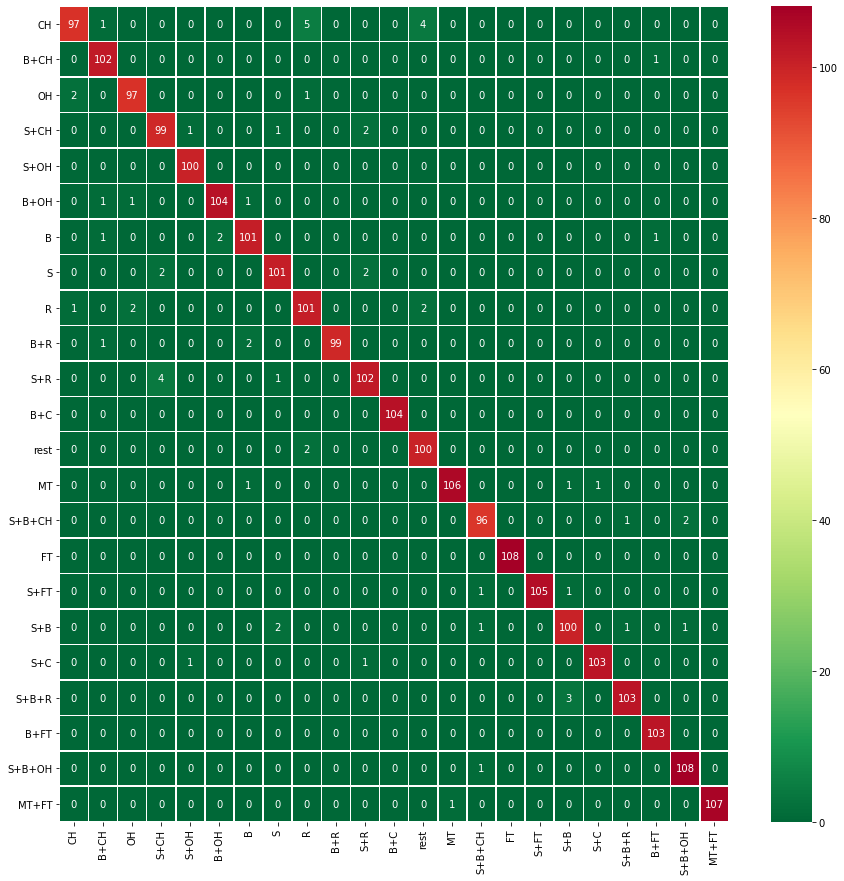

In [18]:
c_p_array = np.zeros([23,23])

cor = [[int(y) for y in x] for x in corr]
for i,j in zip(cor,pred):
    c_p_array[i,j] += 1

df = pd.DataFrame(c_p_array, labels, labels)

plt.figure(figsize=(15,15))
sns.heatmap(data = df, annot=True, fmt = '.0f', linewidths=.5, cmap='RdYlGn_r')

# Test - VGG19, ResNet34, EfficientNet-B0, B1, B2

In [19]:
test_dataset = DrumDataset_test(labels,dataset_test_path,dtype='mel')
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 0)

del test_dataset

In [20]:
total_test = 0
correct_test = 0
correct_test_3 = 0
pred = []
corr = []

save_path="E:parameter/efficientnet_b0_result_mel_aug.pth"

net = EfficientNet.from_name('efficientnet-b0',in_channels=3, num_classes = 23)
net.load_state_dict(torch.load(save_path))
net.eval()
net.to(device)

with torch.no_grad():
    for input_test,label_test in test_loader:
        input_test = input_test.cuda()
        label_test = label_test.cuda()
        input_test = input_test.to("cuda").float()
        label_test = label_test.to("cuda").long()

        pred_test = net(input_test)
        _, predicted = torch.max(pred_test, 1)
        _, predicted_3 = torch.topk(pred_test,3)

        correct_test += torch.sum(predicted == label_test)
        total_test += len(label_test)
        
        if len(label_test) < 8:
            for n,i in enumerate(label_test): # rest bach size
                correct_test_3 += torch.sum(predicted_3[n] == i)
        else:
            for i in range(8): # bach size
                correct_test_3 += torch.sum(predicted_3[i] == label_test[i])
                
        corr.append(label_test.cpu().tolist())
        pred.append(predicted.cpu().tolist())
    
temp = 100*correct_test.cpu().tolist()/total_test
temp_3 = 100*correct_test_3.cpu().tolist()/total_test
print('Testset Top-1 Accuracy: ' + str(temp))
print('Testset Top-3 Accuracy: ' + str(temp_3))

Testset Top-1 Accuracy: 93.1784107946027
Testset Top-3 Accuracy: 98.57571214392803


<AxesSubplot:>

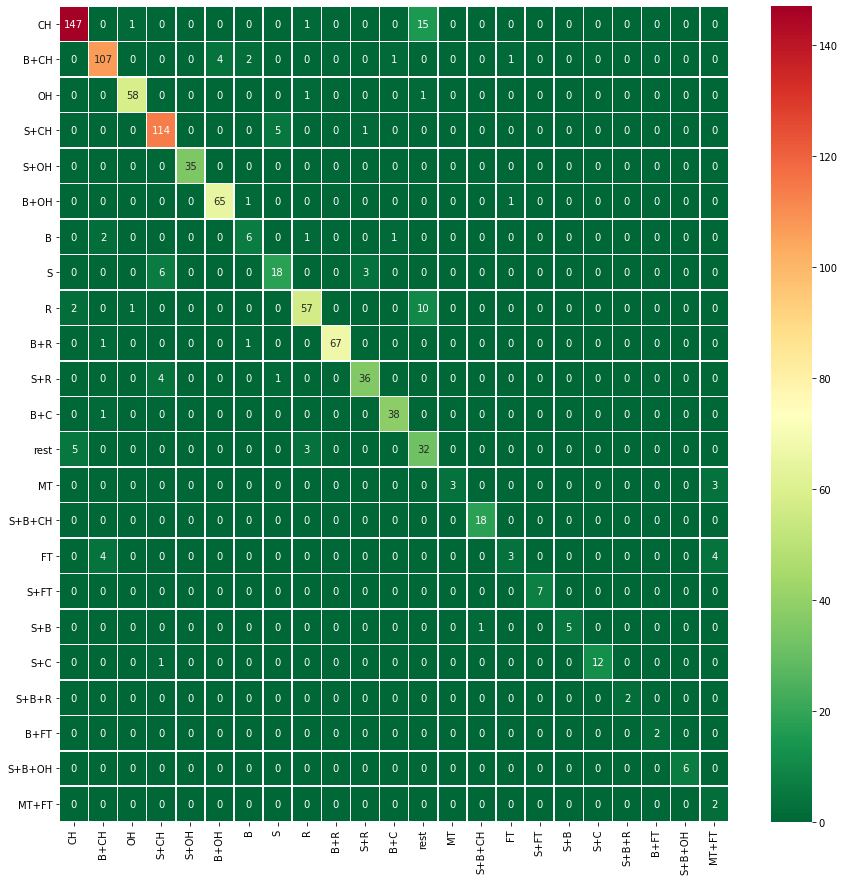

In [21]:
c_p_array = np.zeros([23,23])

cor = [[int(y) for y in x] for x in corr]
for i,j in zip(cor,pred):
    c_p_array[i,j] += 1

df = pd.DataFrame(c_p_array, labels, labels)

plt.figure(figsize=(15,15))
sns.heatmap(data = df, annot=True, fmt = '.0f', linewidths=.5, cmap='RdYlGn_r')